# Data cleaning notebook for "order dataset"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
dataset = pd.read_csv('orders.csv')
c_df = dataset.copy()
c_df.head()

,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method
0,O000001,2023-08-27,U4418,P1477,2,794.70,30.0,App,Wallet
1,O000002,2024-08-06,U3995,P0935,5,1912.46,20.0,Mobile,UPI
2,O000003,2024-11-29,U5880,P1126,2,621.70,0.0,Mobile,UPI
3,O000004,2025-07-03,U1969,P1491,6,1679.62,0.0,App,UPI
4,O000005,2024-04-20,U1925,P0274,2,658.59,20.0,App,Wallet


In [ ]:
df_orders = pd.DataFrame(c_df)
df_orders.head()

,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method
0,O000001,2023-08-27,U4418,P1477,2,794.70,30.0,App,Wallet
1,O000002,2024-08-06,U3995,P0935,5,1912.46,20.0,Mobile,UPI
2,O000003,2024-11-29,U5880,P1126,2,621.70,0.0,Mobile,UPI
3,O000004,2025-07-03,U1969,P1491,6,1679.62,0.0,App,UPI
4,O000005,2024-04-20,U1925,P0274,2,658.59,20.0,App,Wallet


In [ ]:
#initial audit
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          40000 non-null  object 
 1   order_date        40000 non-null  object 
 2   user_id           40000 non-null  object 
 3   sku_id            40000 non-null  object 
 4   quantity          40000 non-null  int64  
 5   price_per_unit    37983 non-null  float64
 6   discount_applied  38788 non-null  float64
 7   order_channel     40000 non-null  object 
 8   payment_method    40000 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 2.7+ MB


In [ ]:
#null values
df_orders.isnull().sum()

,0
order_id,0
order_date,0
user_id,0
sku_id,0
quantity,0
price_per_unit,2017
discount_applied,1212
order_channel,0
payment_method,0


In [ ]:
df_orders.value_counts().sum()

np.int64(36833)

In [ ]:
df_orders.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,40000.0,2.048975,1.388461,-9.00,1.000,2.00,3.000,10.00
price_per_unit,37983.0,1143.434964,551.570224,180.05,678.995,1114.51,1565.725,2499.83
discount_applied,38788.0,18.157420,12.509064,0.00,5.000,20.00,30.000,40.00


In [ ]:
#date time conversion
df_orders['order_date'] = pd.to_datetime(df_orders['order_date'], errors='coerce')

In [ ]:
string_columns = ['order_id', 'user_id', 'sku_id', 'order_channel', 'payment_method']
for col in string_columns:
    df_orders[col] = df_orders[col].astype(str).str.strip().str.lower()

In [ ]:
df_orders['order_date'].dtype

dtype('<M8[ns]')

# HANDLING MISSING VALUE

In [ ]:
df_orders['price_missing'] = df_orders['price_per_unit'].isna().astype(int)

In [ ]:
# sku‑level median (best if many repeats per sku)
sku_median_price = (
    df_orders.groupby('sku_id')['price_per_unit']
             .transform(lambda s: s.median(skipna=True))
)
df_orders['price_per_unit'] = df_orders['price_per_unit'].fillna(sku_median_price)

In [ ]:
global_median = df_orders['price_per_unit'].median()
df_orders['price_per_unit'] = df_orders['price_per_unit'].fillna(global_median)

In [ ]:
df_orders['discount_missing'] = df_orders['discount_applied'].isna().astype(int)
df_orders['discount_applied']  = df_orders['discount_applied'].fillna(0.0)


In [ ]:
df_orders.isnull().sum()

,0
order_id,0
order_date,0
user_id,0
sku_id,0
quantity,0
price_per_unit,0
discount_applied,0
order_channel,0
payment_method,0
price_missing,0


## Revenue & Feature Engineering

In [ ]:
#AFTER ANALYSIS
df_orders['discount_factor'] = df_orders['discount_applied'] / 100.0   # 15 → 0.15


In [ ]:
# Discount amount (absolute ₹ or $)
df_orders['discount_amount'] = df_orders['price_per_unit'] * df_orders['discount_factor']


In [ ]:
# Net selling price after discount
df_orders['net_price'] = df_orders['price_per_unit'] - df_orders['discount_amount']

In [ ]:
# Line‑level revenue (per order line)
df_orders['line_revenue'] = df_orders['net_price'] * df_orders['quantity']


In [ ]:
# Effective % discount (safety check)
df_orders['effective_discount_pct'] = df_orders['discount_factor']

In [ ]:
# Calendar features for seasonality & demand patterns
df_orders['order_year']      = df_orders['order_date'].dt.year
df_orders['order_month']     = df_orders['order_date'].dt.month
df_orders['order_quarter']   = df_orders['order_date'].dt.quarter
df_orders['order_dayofweek'] = df_orders['order_date'].dt.dayofweek   # 0=Mon
df_orders['is_weekend']      = df_orders['order_dayofweek'].isin([5, 6])


In [ ]:
df_orders[['price_per_unit','discount_applied','net_price','line_revenue']].describe().T.head()


,count,mean,std,min,25%,50%,75%,max
price_per_unit,40000.0,1141.845941,538.829553,180.0500,703.165000,1114.05500,1537.4450,2499.83
discount_applied,40000.0,17.607250,12.705217,0.0000,5.000000,15.00000,25.0000,40.00
net_price,40000.0,960.119258,520.763365,108.0300,550.296000,877.18100,1291.5445,2499.83
line_revenue,40000.0,1972.491000,1853.127547,-14654.6715,808.125375,1464.67325,2646.7440,16670.78


In [ ]:
# Example: cap at 1st / 99th percentile
lower_cap = df_orders['line_revenue'].quantile(0.01)
upper_cap = df_orders['line_revenue'].quantile(0.99)

df_orders['line_revenue_capped'] = df_orders['line_revenue'].clip(lower_cap, upper_cap)



In [ ]:
# from scipy import stats

# # Remove outliers using Z-score method (optional, more aggressive)
# z_scores = np.abs(stats.zscore(df_orders['line_revenue_capped']))
# df_no_outliers = df_orders[z_scores < 3]


In [ ]:
df_orders[['order_year', 'order_quarter', 'is_weekend']].head()


,order_year,order_quarter,is_weekend
0,2023,3,True
1,2024,3,False
2,2024,4,False
3,2025,3,False
4,2024,2,True


In [ ]:

df_orders[['price_per_unit', 'discount_applied']].describe()

,price_per_unit,discount_applied
count,40000.000000,40000.000000
mean,1141.845941,17.607250
std,538.829553,12.705217
min,180.050000,0.000000
25%,703.165000,5.000000
50%,1114.055000,15.000000
75%,1537.445000,25.000000
max,2499.830000,40.000000


# Outlier Inspection

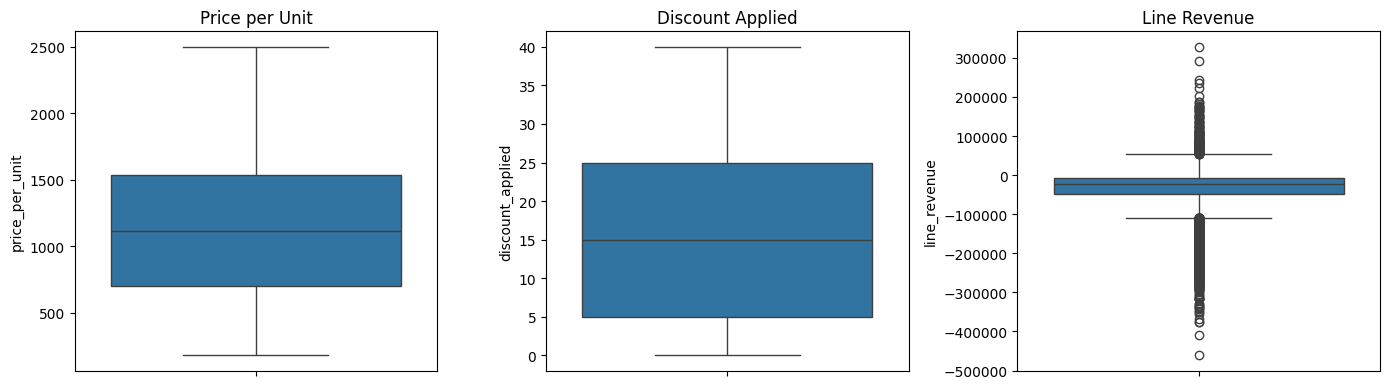

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,4))

plt.subplot(1, 3, 1)
sns.boxplot(y=df_orders['price_per_unit'])
plt.title('Price per Unit')

plt.subplot(1, 3, 2)
sns.boxplot(y=df_orders['discount_applied'])
plt.title('Discount Applied')

plt.subplot(1, 3, 3)
sns.boxplot(y=df_orders['line_revenue'])
plt.title('Line Revenue')

plt.tight_layout()
plt.show()


In [ ]:
# Count fully duplicated rows
df_orders.duplicated().sum()


np.int64(0)

In [ ]:
df_orders[df_orders.duplicated()].head()


,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,net_price,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped


In [ ]:
df_orders['order_id'].duplicated().sum()


np.int64(0)

| Step | Task                               | Status  |
| ---- | ---------------------------------- | ------- |
| 1    | Null values check + imputations    |  Done   |
| 2    | Datatype casting + consistency fix | Done    |
| 3    | Revenue & feature engineering      | Done    |
| 4    | Outlier capping (1st/99th pct)     | Done    |
| 5    | Duplicate check                    | Clean   |


 # Business Rules & Sanity Checks

In [ ]:
# # 1. Quantity must be greater than 0
# df_orders[df_orders['quantity'] <= 0]

In [ ]:
# Remove rows with invalid (non-positive) quantities
df_orders[df_orders['quantity'] > 0]


,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped,line_revenue_check
0,O000001,2023-08-27,U4418,P1477,2,794.70,30.0,App,Wallet,0,...,1112.580,0.3,2023,8,3,6,True,0.3,1112.58000,1112.580
1,O000002,2024-08-06,U3995,P0935,5,1912.46,20.0,Mobile,UPI,0,...,7649.840,0.2,2024,8,3,1,False,0.2,7649.84000,7649.840
2,O000003,2024-11-29,U5880,P1126,2,621.70,0.0,Mobile,UPI,0,...,1243.400,0.0,2024,11,4,4,False,0.0,1243.40000,1243.400
3,O000004,2025-07-03,U1969,P1491,6,1679.62,0.0,App,UPI,0,...,10077.720,0.0,2025,7,3,3,False,0.0,8499.42171,10077.720
4,O000005,2024-04-20,U1925,P0274,2,658.59,20.0,App,Wallet,0,...,1053.744,0.2,2024,4,2,5,True,0.2,1053.74400,1053.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39994,O039995,2023-07-15,U5153,P0882,1,1876.68,20.0,Mobile,COD,0,...,1501.344,0.2,2023,7,3,5,True,0.2,1501.34400,1501.344
39995,O039996,2024-05-04,U1041,P1437,2,1450.58,10.0,Mobile,COD,0,...,2611.044,0.1,2024,5,2,5,True,0.1,2611.04400,2611.044
39996,O039997,2024-08-26,U5734,P0983,1,319.39,30.0,Mobile,UPI,0,...,223.573,0.3,2024,8,3,0,False,0.3,223.57300,223.573
39998,O039999,2025-07-05,U4034,P1254,3,506.92,0.0,App,UPI,0,...,1520.760,0.0,2025,7,3,5,True,0.0,1520.76000,1520.760


In [ ]:
# 2. Price per unit must be greater than 0
df_orders[df_orders['price_per_unit'] <= 0]


,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,net_price,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped


In [ ]:
# 3. Discount applied must be between 0 and 100 (or your business limit, e.g., 50)
df_orders[(df_orders['discount_applied'] < 0) | (df_orders['discount_applied'] > 50)]

,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,net_price,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped


In [ ]:
# 4. Net price should not exceed price per unit
df_orders[df_orders['net_price'] > df_orders['price_per_unit']]

,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,net_price,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped


In [ ]:
# 5. Line revenue should match net_price * quantity (recalculate)
df_orders['line_revenue_check'] = df_orders['net_price'] * df_orders['quantity']
df_orders[df_orders['line_revenue'] != df_orders['line_revenue_check']]


,order_id,order_date,user_id,sku_id,quantity,price_per_unit,discount_applied,order_channel,payment_method,price_missing,...,line_revenue,effective_discount_pct,order_year,order_month,order_quarter,order_dayofweek,is_weekend,discount_factor,line_revenue_capped,line_revenue_check


# -------------------------------------DONE----------------------------------

In [ ]:
cleaned_filename = 'cleaned_orders.csv'
df_orders.to_csv(cleaned_filename, index=False)

# **Light exploratory data analysis**